In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
import torchaudio
import aubio
import os
import matplotlib.pyplot as plt
import random

In [2]:
os.chdir('./ML Corpus 2/')
cd = os.getcwd()      


filenames = []

for (root,dirs,files) in os.walk(cd, topdown=True): 
    for name in files:
          if name.endswith('.'+'wav'):
            filenames.append(os.path.join(root, name))

In [3]:
def audio_to_encoded(filename, bar_length):

    #Setting variables for time-base etc.
    per_quarter_note = 48
    timebase= per_quarter_note*4
    sr = 44100
    win_s = 512
    hop_length = win_s // 2
    dur = None
    bar_length = 1
    # Load the audio file
    s = aubio.source(filename, sr, hop_length)
    sr = aubio.source.get_samplerate(s)

    #set 16ths and ppqn values based on bar length
    num_ppqn = timebase*bar_length
    sixteenths_div = 16*bar_length

    # Load the audio file
    s = aubio.source(filename, sr, hop_length)
    sr = aubio.source.get_samplerate(s)
    dur = s.duration
    
    #aubio.onset
    o = aubio.onset("default", win_s, hop_length, sr)
    aubio.onset.set_threshold(o,0.8)
    # list of onsets, in samples
    onsets = []           
    
    total_frames = 0
    while True:
        samples, read = s()

        if o(samples):
            onsets.append(int(o.get_last()))
        total_frames += read
        if read < hop_length: break
    
    # Set the desired range for onsets
    desired_range = 16 * bar_length
    
    # Check if onsets is greater than the desired range
    while len(onsets) > desired_range:
        # Double the bar_length
        bar_length *= 2
    
        # Recalculate the desired range based on the updated bar_length
        desired_range = 16 * bar_length
        # Insert onset at the beginning
        onsets = np.insert(onsets, 0, 0)

    #Define ppqn and sixteenth note sizes
    ppqn_timebase = round(dur / num_ppqn)
    sixteenths = round(dur / sixteenths_div)

    #Initialise slice arrays
    steps = []
    ppqn_slices = []

    #Get 16th note slice points
    for f in range(sixteenths_div):
        out= f * sixteenths
        steps=np.append(steps, out)
    #Get PPQN slice points
    for f in range(num_ppqn):
        out= f * ppqn_timebase
        ppqn_slices=np.append(ppqn_slices, out)

    # Convert onset times to integers using np.round
    onsets = np.round(onsets).astype(int)

    # Round onset points down to the nearest sixteenth note and disgard double event triggers
    onset_points_rounded = []
    previous_rounded_onset = None
    keep_mask = np.ones(len(onsets), dtype=bool)
    for i, onset in enumerate(onsets):
        rounded_onset = int(round(onset / sixteenths))
        # Check if the current rounded onset is the same as the previous one
        if rounded_onset != previous_rounded_onset:
            onset_points_rounded.append(rounded_onset)
            previous_rounded_onset = rounded_onset
        else:
            # If the onset is a duplicate, mark it for removal
            keep_mask[i] = False


    # Filter the 'onsets' array to keep only the onsets that haven't been processed
    onsets = onsets[keep_mask]

    #Round onsets to nearest PPQN timebase point
    ppqn_onsets = [int(onset // ppqn_timebase) * ppqn_timebase for onset in onsets]

    # One-hot encode the rounded onset points in an array of length 16
    num_sixteenths = sixteenths_div
    ohe_sixteenths = np.zeros(num_sixteenths)
    for onset in onset_points_rounded:
        if onset < num_sixteenths:
            ohe_sixteenths[onset] = 1

    #Get distances of substeps from nearest 16th note
    substeps = []
    quantize_points_rounded_sixteenths = [int(round(ppqn_timebase / sixteenths)) * sixteenths for ppqn_timebase in onsets]
    for f, c in zip(ppqn_onsets, quantize_points_rounded_sixteenths):
        m = f - c
        ss = m //ppqn_timebase
        s = (ss - -6) / (6 - -6)
        if s >= 1:
            substeps = np.append(substeps,s)
        else:
            substeps = np.append(substeps,s)


    #Match substep values to corresponding event
    substeps_full = []
    j = 0  # Index for substeps array
    for binary_value in ohe_sixteenths:
        if binary_value == 1 and j < len(substeps):
            substeps_full.append(substeps[j])
            j += 1
        else:
            substeps_full.append(0)
            
            
#     #append arrays together
    op= np.concatenate((ohe_sixteenths, substeps_full))
    
    return op
    

In [4]:
test = audio_to_encoded(filenames[2],1)
print(test)

[1.         1.         0.         1.         0.         1.
 0.         1.         0.         1.         0.         1.
 0.         1.         0.         1.         0.5        0.
 0.         0.41666667 0.         0.         0.         0.41666667
 0.         0.         0.         0.41666667 0.         0.
 0.         0.41666667]


In [5]:
print("Dataset Length:", len(filenames))
dataset=np.zeros((len(filenames),32))

for i in range(len(filenames)):
    dataset[i,:] = audio_to_encoded(filenames[i],1)
print("Dataset processed: ", dataset.shape)

Dataset Length: 168
Dataset processed:  (168, 32)


In [6]:
# Define the Autoencoder
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(32, 8),
            nn.ReLU(),
            # nn.Dropout(p=0.5),
            nn.Linear(8, 4),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(4, 8),
            nn.ReLU(),
            # nn.Dropout(p=0.5),
            nn.Linear(8, 32),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    def decode(self, latent):
        return self.decoder(latent)

losses = []
# Train the autoencoder
def train_autoencoder(model, dataloader, num_epochs=50, learning_rate=0.001):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0

        for batch, _ in dataloader:
            # Forward pass
            reconstructed = model(batch)
            loss = criterion(reconstructed, batch)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
        losses.append(loss.item())
        if epoch % 1 == 0:
            
            print(f"Epoch [{epoch}/{num_epochs}] Loss: {total_loss / len(dataloader)}")


In [7]:
AE = Autoencoder()

In [8]:

d_data = torch.tensor(dataset, dtype=torch.float32)
t_dataset = TensorDataset(d_data, d_data)  # Input and target are the same
dataloader = DataLoader(t_dataset, batch_size=16, shuffle=True)

In [9]:
train_autoencoder(AE, dataloader, num_epochs=50)

Epoch [0/50] Loss: 0.1806696355342865
Epoch [1/50] Loss: 0.17853086374022745
Epoch [2/50] Loss: 0.17543342980471524
Epoch [3/50] Loss: 0.17336023260246625
Epoch [4/50] Loss: 0.17074298452247272
Epoch [5/50] Loss: 0.1688620840961283
Epoch [6/50] Loss: 0.16607678072019058
Epoch [7/50] Loss: 0.16280597448349
Epoch [8/50] Loss: 0.16081326658075507
Epoch [9/50] Loss: 0.1582549431107261
Epoch [10/50] Loss: 0.1566785154017535
Epoch [11/50] Loss: 0.15451547097076068
Epoch [12/50] Loss: 0.15149990130554547
Epoch [13/50] Loss: 0.14844083244150336
Epoch [14/50] Loss: 0.14602945067665793
Epoch [15/50] Loss: 0.14366863667964935
Epoch [16/50] Loss: 0.14180010895837436
Epoch [17/50] Loss: 0.13871470093727112
Epoch [18/50] Loss: 0.13541091368957
Epoch [19/50] Loss: 0.13448370722207156
Epoch [20/50] Loss: 0.1311246007680893
Epoch [21/50] Loss: 0.12976381859996103
Epoch [22/50] Loss: 0.12789350138469177
Epoch [23/50] Loss: 0.12514922226017172
Epoch [24/50] Loss: 0.12240747768770564
Epoch [25/50] Loss: 0

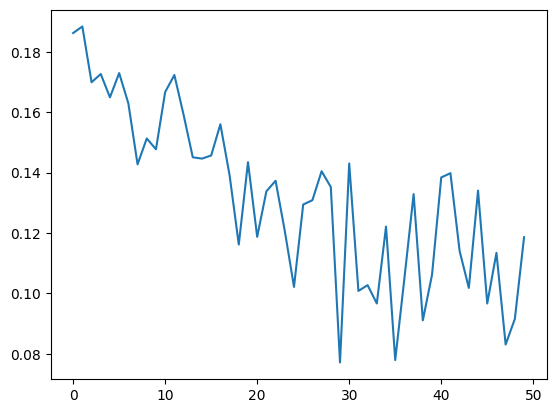

In [10]:
plt.plot(losses)
plt.show()

In [15]:

def Generate(tolerance=0.5):
    latent_vector = torch.rand((1, 4))  # Random latent vector
    generated_rhythm = AE.decode(latent_vector)
    
    split = torch.split(generated_rhythm[0],16)
    
    steps = split[0]
    
    substeps = split[1]
    
    output1 = []
    output2 = []
    seq=[]
    
    for op in steps:
        if op > tolerance:
            output1.append(1)
        else: output1.append(0)
            
    for s in substeps:
        op = int(s * (6 - -6) + -6)
        output2.append(op)
        
    # print('AE: Raw Generation: ',generated_rhythm[0])
    print('Step on/off: ',output1)
    print('48-PPQN substeps ',output2)

    client.send_message('/rhythm', output1)
    
    # probs = nn.Softmax()
    # steps = probs(steps)
    
    # # print(steps)
    # steps = torch.multinomial(steps, 8)
    # # print(steps)
    
    # op = torch.zeros(16)
    
    # for step in steps:
    #     op[step] = 1
    
    # print("Probability steps: ", op)


In [14]:
from pythonosc import dispatcher
from pythonosc import udp_client
from pythonosc import osc_server

client = udp_client.SimpleUDPClient('127.0.0.1', 8003)

In [88]:
Generate(0.66)

Step on/off:  [1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1]
48-PPQN substeps  [0, -2, -1, -1, -2, -1, -2, -1, -1, -2, -1, -1, -1, -1, -1, -1]


In [ ]:
def audio_MIDI(filenames,seq_len=16):
    downsample = 1
    samplerate = 44100 // downsample
    win_s = 512 // downsample  # FFT size
    hop_s = 256 // downsample  # Hop size
    
    # Initialize lists to store data
    X_notes_list = []
    X_velocity_list = []
    y_notes_list = []
    y_velocity_list = []

    for idx, file in enumerate(filenames):
        # Load audio file
        s = aubio.source(file, samplerate, hop_s)
        samplerate = s.samplerate

        notes_o = aubio.notes("default", win_s, hop_s, samplerate)
        notes = []
        velocities = []

        # Read audio and extract MIDI notes and velocities
        while True:
            samples, read = s()
            new_note = notes_o(samples)
            if new_note[0] != 0:  # Only consider non-zero notes
                notes.append(new_note[0] / 127)  # Normalize note value
                velocities.append(new_note[1] / 127)  # Normalize velocity value
            if read < hop_s:
                break

        # Ensure consistent sequence length (pad or truncate)
        if len(notes) < seq_len + 1:
            # Pad sequences with zeros
            notes += [0] * (seq_len + 1 - len(notes))
            velocities += [0] * (seq_len + 1 - len(velocities))
        else:
            # Truncate sequences
            notes = notes[:seq_len + 1]
            velocities = velocities[:seq_len + 1]

        # Create input-output pairs
        X_notes_list.append(notes[:-1])  # Input sequence
        X_velocity_list.append(velocities[:-1])  # Input sequence
        y_notes_list.append(notes[1:])  # Target sequence
        y_velocity_list.append(velocities[1:])  # Target sequence

    # Convert lists to tensors
    X_notes = torch.tensor(X_notes_list, dtype=torch.float32)
    X_velocity = torch.tensor(X_velocity_list, dtype=torch.float32)
    y_notes = torch.tensor(y_notes_list, dtype=torch.float32)
    y_velocity = torch.tensor(y_velocity_list, dtype=torch.float32)

    return X_notes, X_velocity, y_notes, y_velocity



X_notes, X_velocity, y_notes, y_velocity = audio_MIDI(filenames)



In [ ]:
print(X_notes.shape)

In [ ]:
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size,nonlinearity='relu',dropout=0.5):
        super(SimpleRNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out)
        return out

input_size = 1
hidden_size = 50
output_size = 1
model = SimpleRNN(input_size, hidden_size, output_size)

In [ ]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
losses = []
# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    outputs = model(X_notes.unsqueeze(2))  # Add a dimension for input size
    loss = criterion(outputs, y_notes.unsqueeze(2))
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

In [ ]:
plt.plot(losses)
plt.show()

In [ ]:
model.eval


In [ ]:
midi_note = random.randint(40,70)
seq = []
print(midi_note)
midi_note = midi_note / 127
print(midi_note)
for i in range(8):
    seed = torch.tensor([[[midi_note]]], dtype=torch.float32)
    note_gen = model(seed)
    note_gen = int(note_gen * 127)
    midi_note = note_gen / 127
    seq.append(note_gen)

print(seq)



In [ ]:
midi_note = 75 / 127
seed = torch.tensor([[[midi_note]]], dtype=torch.float32)
note_gen = model(seed)
midi_note = note_gen
note_gen = int(note_gen * 127 + 24)
print(note_gen)

In [ ]:
a = torch.tensor([[0,0,1,0,0,0],[1,0,0,1,1,1]],dtype=torch.float)
print(a)
sm = nn.Softmax()
op = sm(a)
flip = np.random.randint(2)
print(op)
mn = torch.multinomial(op,1)
print(mn)
# print(a[flip][mn])


In [ ]:
def audio_One_Hot(filenames):
    downsample = 1
    samplerate = 44100 // downsample
    win_s = 512 // downsample  # FFT size
    hop_s = 256 // downsample  # Hop size
    notes = []
    for idx, file in enumerate(filenames):
        # Load audio file
        s = aubio.source(file, samplerate, hop_s)
        samplerate = s.samplerate

        notes_o = aubio.notes("default", win_s, hop_s, samplerate)
        
        
        # Read audio and extract MIDI notes and velocities
        while True:
            samples, read = s()
            new_note = notes_o(samples)
            if new_note[0] != 0:  # Only consider non-zero notes
                notes.append(new_note[0])  # Normalize note value
                # print(new_note[0])
                # velocities.append(new_note[1] / 127)  # Normalize velocity value
            if read < hop_s:
                break

    X = torch.zeros([len(notes[:-1]), 127])
    y = torch.zeros([len(notes[:-1]), 127])

    for i, note in enumerate(notes[:-1]):
        X[i][int(note)] = 1
        y[i][int(note + 1)] = 1

    # print(len(notes))
    return X, y
          



# X_notes, X_velocity, y_notes, y_velocity = audio_MIDI(filenames)
X, y = audio_One_Hot(filenames)




In [ ]:
print(64 /2)
    



In [ ]:
# Define the Autoencoder
class Pitch_Autoencoder(nn.Module):
    def __init__(self):
        super(Pitch_Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(127, 64),
            nn.ReLU(),
            # nn.Dropout(p=0.5),
            nn.Linear(64, 32),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            # nn.Dropout(p=0.5),
            nn.Linear(64, 127),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    def decode(self, latent):
        return self.decoder(latent)

losses = []
# Train the autoencoder
def train_autoencoder(model, dataloader, num_epochs=50, learning_rate=0.001):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0

        for batch, _ in dataloader:
            # Forward pass
            reconstructed = model(batch)
            loss = criterion(reconstructed, batch)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
        losses.append(loss.item())
        if epoch % 1 == 0:
            
            print(f"Epoch [{epoch}/{num_epochs}] Loss: {total_loss / len(dataloader)}")


In [ ]:
aeMidi = Pitch_Autoencoder()

In [ ]:
p_dataset = TensorDataset(X, y)  # Input and target are the same
dataloader = DataLoader(p_dataset, batch_size=16, shuffle=True)

In [ ]:
train_autoencoder(aeMidi, dataloader, num_epochs=50, learning_rate=0.001)

In [ ]:
plt.plot(losses)
plt.show()

In [ ]:
a = aeMidi(X[0])

sm = nn.Softmax()
op = sm(a)
# print(op)
mn = torch.multinomial(op,1)
print(mn)
# print(a[flip][mn])


In [ ]:


r = model(X[0:2])
print(r)